# MCMC for Linear regression with normal distribution

In [1]:
# import libraries
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
import pickle
import logging
from rmh import rmh_inference_loop,plot_rmh
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)

2022-09-08 19:21:19.231135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Lets generate samples now.

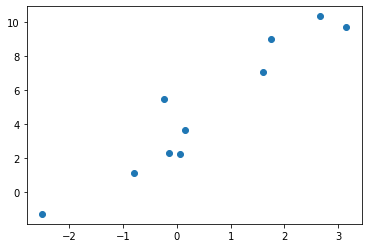

In [22]:
with open("../data/linear_regression/linear_regression",'rb') as f:
    data = pickle.load(f)
x = jnp.array(data['data']['x'])
def identity_trans(x):
    return jnp.append(jnp.ones((x.shape[0],1)),x,axis=1)
m = x.shape[0]
x_trans = identity_trans(x)
y = jnp.array(data['data']['y'])
prior_mean = jnp.array(data['prior']['mean'])
prior_var = jnp.array(data['prior']['var'])
noise_var = data['noise_variance']
plt.scatter(x,y)

In [3]:
def create_log_postfn(x_trans,y,prior_mean,prior_var):
  n = x_trans.shape[1]
  prior_normal = tfd.MultivariateNormalFullCovariance(
      loc = prior_mean,covariance_matrix= prior_var
  )
  y = y.reshape(m,)

  def log_postfn(theta):
    # from the above equation
    # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
    theta = theta['theta']
    log_prior = prior_normal.log_prob(theta)
    # log_likelihood
    mean = (x_trans@theta.reshape(n,1)).reshape(m,)
    likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,jnp.identity(m))
    log_like = jnp.array(likelihood_normal.log_prob(y))
    return (log_like+log_prior)
    
  return log_postfn
log_postfn = create_log_postfn(x_trans,y,prior_mean,prior_var)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [4]:
initial = {"theta":(prior_mean)}

Lets generate samples from posterior distribution now.

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

In [108]:
n = 2
states = rmh_inference_loop(log_postfn,jnp.identity(n) * 0.7,initial,1000)

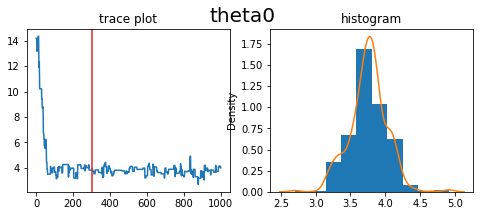

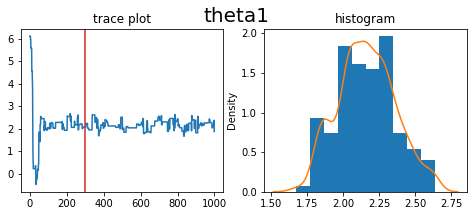

In [109]:
burnin = 300
plot_rmh(states,burnin,contains_arrays=True)

In [110]:
seed = jax.random.PRNGKey(5)


def predict_mcmc(seed,x_test):
    sample_from_each = 10
    def one_step(carry, state):

        theta = state.position['theta']
        mean = (x_test@theta.reshape(n,1)).reshape(x_test.shape[0],)
        likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,jnp.identity(x_test.shape[0]))
        y = likelihood_normal.sample(seed=carry,sample_shape=sample_from_each)
        carry,_ = jax.random.split(seed)
        
        return carry, y

    _, y_stacks = jax.lax.scan(one_step, seed, states)
    y_stacks = y_stacks.reshape(-1,x_test.shape[0])


    mean = y_stacks.mean(axis=0)
    std_dev = y_stacks.std(axis=0)
    return mean, std_dev


# mcmc_pred_mean, mcmc_pred_sigma = mcmc_pred_mean.reshape(xx.shape), mcmc_pred_sigma.reshape(xx.shape)

In [111]:
x_linspace = jnp.linspace(-4,4)
x_trans_linspace = identity_trans(x_linspace.reshape((-1,1)))
mcmc_pred_mean, mcmc_pred_sigma = predict_mcmc(seed,x_trans_linspace)

(1000, 10, 50)


In [98]:
x_linspace.shape

(50,)

In [99]:
mcmc_pred_mean.shape

(50,)

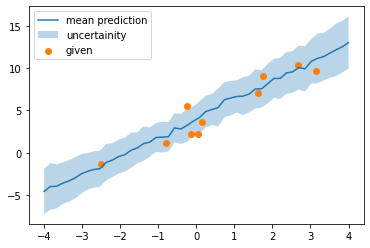

In [105]:
plt.plot(x_linspace,mcmc_pred_mean,label="mean prediction")
plt.fill_between(x_linspace,mcmc_pred_mean+mcmc_pred_sigma,mcmc_pred_mean-mcmc_pred_sigma,alpha=0.3,label="uncertainity")
plt.scatter(data['data']['x'],jnp.array(data['data']['y']),label='given')
plt.legend()

In [10]:
from pandas import to_pickle
to_pickle(states,"../results/linear_regression/results_data/MCMC_Blackjax")

Now lets see how well the samples are fitting our initial data.

I will just compare with the actual pdf.